# WaveBot MASK Workshop

In [1]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt

import wecopttool as wot


## 1. WEC object
### Mesh

We already include the mesh for the WaveBot in WecOptTool. For other devices you would have to create the geometry and mesh. See the WaveBot mesh as an example.

In [2]:
wb = wot.geom.WaveBot()
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)


### DOFs
We will model a 1 DOF (heave) case.

In [3]:
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
fb.add_translation_dof(name="Surge")
ndof = fb.nb_dofs


### Hydrostatics
We will use WecOptTool's `hydrostatics` module to get the mass and hydrostatic stiffness. 

In [4]:
hydro_stiffness = wot.hydrostatics.stiffness_matrix(fb).values  # N/m
mass = wot.hydrostatics.inertia_matrix(fb).values  # kg


### Frequencies
Choose frequencies based on your waves & whether you include non-linearities. (Discussion) 

In [5]:
f1 = 0.05  # Hz
nfreq = 50
freq = wot.frequency(f1, nfreq, False)  # Hz, # False -> no zero frequency


### BEM
We provide a function that runs Capytaine. (Take a look)

In [6]:
bem_data = wot.run_bem(fb, freq)


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

### PTO

We will define our PTO based on a PTO impedance (refer to slides and papers). The PTO will be used to 
1. add an additional force to our dynamic equations
1. the objective function: average electrical power

In [7]:
## PTO impedance definition
omega = bem_data.omega.values  # rad/s
gear_ratio = 12.0  # rad/m
torque_constant = 6.7  # N*m/A
winding_resistance = 0.5  # Ω
winding_inductance = 0.0  # H
drivetrain_inertia = 2.0  # kg*m^2
drivetrain_friction = 1.0  # N*m*s/rad
drivetrain_stiffness = 0.0  # N*m/rad

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance

pto_impedance_00 = np.zeros(omega.shape)

pto_impedance = np.array([
    [pto_impedance_11, pto_impedance_00, pto_impedance_12, pto_impedance_00],
    [pto_impedance_00, pto_impedance_11, pto_impedance_00, pto_impedance_12],
    [pto_impedance_21, pto_impedance_00, pto_impedance_22, pto_impedance_00],
    [pto_impedance_00, pto_impedance_21, pto_impedance_00, pto_impedance_22],
])


In [8]:
f_max = 1000 # N
f_max_x = 200 # N

def saturated_pi(pto, wec, x_wec, x_opt, waves=None, nsubsteps=1):
    saturation = np.array([[-np.infty, f_max], [-f_max_x, np.infty]])
    return wot.pto.controller_pi(pto, wec, x_wec, x_opt, waves, nsubsteps, saturation=saturation, symmetric=False)


In [9]:
## Create PTO object
pto_name = ['PTO_Heave', 'PTO_Surge']
kinematics = np.eye(ndof)
controller = saturated_pi
loss = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, pto_name)


### Constraints

In [10]:
constraints = [
]


### Additional forces

In [11]:
f_add = {
    'PTO': pto.force_on_wec,
}


### WEC Object

In [12]:
wec = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add,
)


## 2. Waves

In [13]:
regular = True

if regular:
    amplitude = 0.2
    wavefreq = 0.3
    waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)
else:
    fp = 0.3
    Hm0 = 0.2
    omnidirectional_spectrum = wot.waves.omnidirectional_spectrum(
        f1=f1,
        nfreq=nfreq,
        spectrum_func=lambda f: wot.waves.jonswap_spectrum(freq=f, fp=fp, hs=Hm0, gamma=3.3),
        spectrum_name="JONSWAP",
    )
    waves = wot.waves.long_crested_wave(omnidirectional_spectrum, 0, seed=13)


## 3. Objective Function

In [14]:
obj_fun = pto.average_power


## 4. Solve

In [15]:
nstate_opt = wot.pto.nstate_pid(2, 2, False, False)


In [53]:
# Solve
scale_x_wec = 1#e3 # 1e1
scale_x_opt = 1 # 1e-3
scale_obj = 1 # 1e-2

options = {'maxiter': 300}

results = wec.solve(
    waves,
    obj_fun,
    nstate_opt,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    optim_options = options,
)

print(f'Optimal average electrical power: {results.fun} W')

# Post-process
nsubstep_postprocess = 4
wec_fdom, wec_tdom = wec.post_process(results, waves, nsubstep_postprocess)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubstep_postprocess)

# -261 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -258.2002128122416
            Iterations: 177
            Function evaluations: 322
            Gradient evaluations: 177
Optimal average electrical power: -258.2002128122416 W


## 5. Solve PI

In [42]:
def controller_pi(p,w,xw,xo,wa,ns):
    return wot.pto.controller_pi(p,w,xw,xo,wa,ns,symmetric=False)

pto_pi = wot.pto.PTO(ndof, kinematics, controller_pi, pto_impedance, loss, pto_name)
f_add_pi = {'PTO': pto_pi.force_on_wec,}
wec_pi = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add_pi,
)
obj_fun_pi = pto_pi.average_power

scale_x_wec_pi = 1#e1#e1
scale_x_opt_pi = 1#e-3
scale_obj_pi = 1#e-1

options = {'maxiter': 200}

results_pi = wec_pi.solve(
    waves,
    obj_fun_pi,
    nstate_opt,
    scale_x_wec=scale_x_wec_pi,
    scale_x_opt=scale_x_opt_pi,
    scale_obj=scale_obj_pi,
    optim_options = options,
)

print(f'Optimal average electrical power: {results_pi.fun} W')

# Post-process
wec_fdom_pi, wec_tdom_pi = wec_pi.post_process(results_pi, waves, nsubstep_postprocess)
pto_fdom_pi, pto_tdom_pi = pto_pi.post_process(wec_pi, results_pi, waves, nsubstep_postprocess)

# -413 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -413.1053058735712
            Iterations: 69
            Function evaluations: 84
            Gradient evaluations: 69
Optimal average electrical power: -413.1053058735712 W


## 6.Plots

Text(0.5, 1.0, 'Heave')

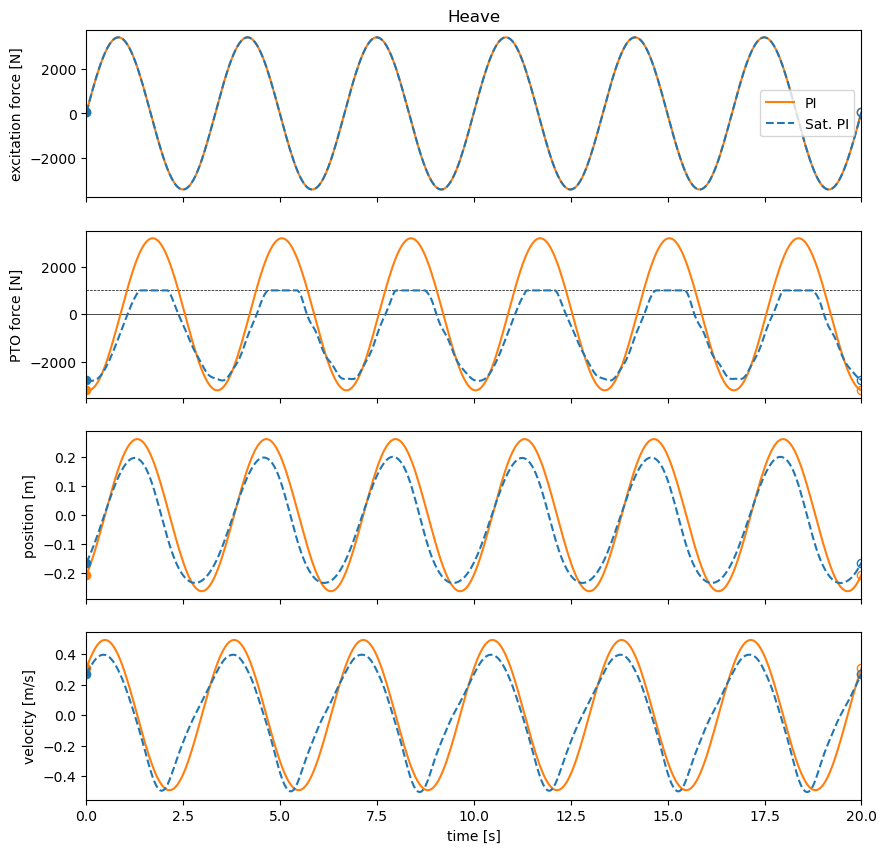

In [54]:
n = 4
fig, ax = plt.subplots(n,1, sharex=True, figsize=(10,10))
plt.xlim([0, wec.tf])
cmap = plt.get_cmap("tab10")

# excitation force
i = 0
y = np.squeeze(wec_tdom['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
               wec_tdom['force'].sel(type='diffraction', influenced_dof='DOF_0'))
y_pi = np.squeeze(wec_tdom_pi['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
                  wec_tdom_pi['force'].sel(type='diffraction', influenced_dof='DOF_0'))

ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")
# ax[i].plot(wec_pi.)

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('excitation force [N]')

# PTO force
i = 1
y = np.squeeze(pto_tdom['force'].sel(dof="PTO_Heave"))
y_pi = np.squeeze(pto_tdom_pi['force'].sel(dof="PTO_Heave"))

ax[i].plot([0, wec.tf], [f_max, f_max], 'k--', linewidth=0.5, label='_nolegend_')
# ax[i].plot([0, wec.tf], [-f_max, -f_max], 'k--', linewidth=0.5, label='_nolegend_')
ax[i].plot([0, wec.tf], [0, 0], 'k-', linewidth=0.5, label='_nolegend_')

ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI') ; ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('PTO force [N]')

# position
i = 2
y = np.squeeze(wec_tdom['pos'].sel(influenced_dof='DOF_0'))

y_pi = np.squeeze(wec_tdom_pi['pos'].sel(influenced_dof='DOF_0'))
ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('position [m]')

# velocity
i = 3
y = np.squeeze(wec_tdom['vel'].sel(influenced_dof='DOF_0'))

y_pi = np.squeeze(wec_tdom_pi['vel'].sel(influenced_dof='DOF_0'))
ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('velocity [m/s]')

#
plt.xlabel("time [s]")
ax[0].legend()
ax[0].set_title("Heave")


Text(0.5, 1.0, 'Surge')

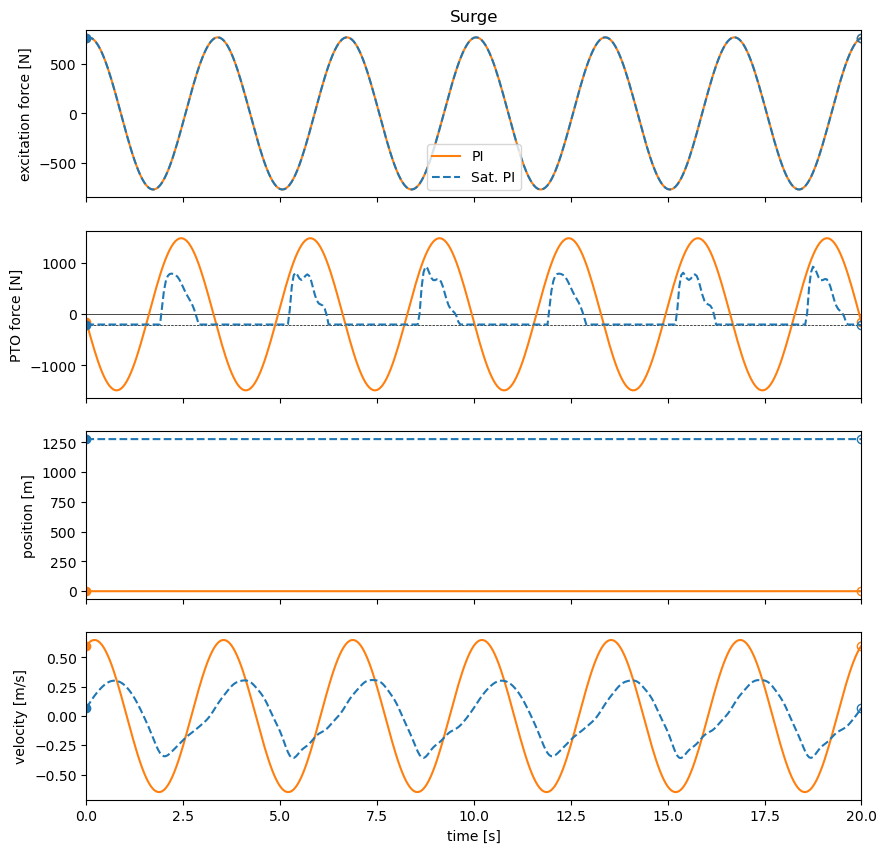

In [55]:
n = 4
fig, ax = plt.subplots(n,1, sharex=True, figsize=(10,10))
plt.xlim([0, wec.tf])
cmap = plt.get_cmap("tab10")

# excitation force
i = 0
y = np.squeeze(wec_tdom['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
               wec_tdom['force'].sel(type='diffraction', influenced_dof='DOF_1'))
y_pi = np.squeeze(wec_tdom_pi['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
                  wec_tdom_pi['force'].sel(type='diffraction', influenced_dof='DOF_1'))

ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")
# ax[i].plot(wec_pi.)

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('excitation force [N]')

# PTO force
i = 1
y = np.squeeze(pto_tdom['force'].sel(dof="PTO_Surge"))
y_pi = np.squeeze(pto_tdom_pi['force'].sel(dof="PTO_Surge"))

# ax[i].plot([0, wec.tf], [f_max, f_max], 'k--', linewidth=0.5, label='_nolegend_')
ax[i].plot([0, wec.tf], [-f_max_x, -f_max_x], 'k--', linewidth=0.5, label='_nolegend_')
ax[i].plot([0, wec.tf], [0, 0], 'k-', linewidth=0.5, label='_nolegend_')

ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI') ; ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('PTO force [N]')

# position
i = 2
y = np.squeeze(wec_tdom['pos'].sel(influenced_dof='DOF_1'))

y_pi = np.squeeze(wec_tdom_pi['pos'].sel(influenced_dof='DOF_1'))
ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('position [m]')

# velocity
i = 3
y = np.squeeze(wec_tdom['vel'].sel(influenced_dof='DOF_1'))

y_pi = np.squeeze(wec_tdom_pi['vel'].sel(influenced_dof='DOF_1'))
ax[i].plot(0, y_pi[0], 'o', color=cmap(1), label='_nolegend_')
ax[i].plot(wec_pi.tf, y_pi[0], 'o', color=cmap(1), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec_pi.time_nsubsteps(nsubstep_postprocess)[-1], wec_pi.tf], [y_pi[-1], y_pi[0]], '-', color=cmap(1), label='_nolegend_')
y_pi.plot(color=cmap(1), ax=ax[i], label='PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].plot(0, y[0], 'o', color=cmap(0), label='_nolegend_')
ax[i].plot(wec.tf, y[0], 'o', color=cmap(0), markerfacecolor='none', label='_nolegend_')
ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '--', color=cmap(0), label='_nolegend_')

y.plot(color=cmap(0), linestyle='--', ax=ax[i], label='Sat. PI'); ax[i].set_xlabel(""); ax[i].set_title("")

ax[i].set_ylabel('velocity [m/s]')

#
plt.xlabel("time [s]")
ax[0].legend()
ax[0].set_title("Surge")


In [56]:
print(f"PI gains: {results_pi.x[-nstate_opt-2:]}")
print(f"Saturated PI gains: {results.x[-nstate_opt-2:]}")


PI gains: [-2.77520185e-19 -1.32579343e-20 -6.55450956e+03  5.63509648e+02
  1.88279340e+03 -2.93278546e+03  4.51128778e+03  4.40157087e+03
 -3.05156730e+03 -3.09787233e+03]
Saturated PI gains: [-6.24996232e-19  2.03171150e-06 -1.28401985e+04  1.29446971e+04
  4.45600697e+03 -1.70398608e+04 -2.92875839e+03 -5.32650924e-01
 -6.00723843e+03 -2.67122760e+00]


In [57]:
np.reshape(results.x[-nstate_opt:-int(nstate_opt/2)], [ndof, ndof])


array([[-12840.19852422,  12944.69707104],
       [  4456.00697315, -17039.86078517]])

In [58]:
np.reshape(results.x[-int(nstate_opt/2):], [ndof, ndof])


array([[-2.92875839e+03, -5.32650924e-01],
       [-6.00723843e+03, -2.67122760e+00]])

In [59]:
np.reshape(results_pi.x[-nstate_opt:-int(nstate_opt/2)], [ndof, ndof])


array([[-6554.50956478,   563.50964779],
       [ 1882.79339763, -2932.78545853]])

In [60]:
np.reshape(results.x[-int(nstate_opt/2):], [ndof, ndof])


array([[-2.92875839e+03, -5.32650924e-01],
       [-6.00723843e+03, -2.67122760e+00]])